In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from timm import create_model
import numpy as np


In [2]:
# Dataset path
data_dir = "E:/1 Paper Work/Cutting Tool Paper/Dataset/cutting tool data/test_data_40_images"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation within 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])


# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Define dataset split
train_size = int(0.7 * len(dataset))  # 60% for training
val_size = int(0.3 * len(dataset))    # 20% for validation
#test_size = len(dataset) - train_size - val_size  # 20% for testing
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Print class names and dataset sizes
print("Classes:", dataset.classes)
print(f"Training samples: {len(train_dataset)} (60%)")
print(f"Validation samples: {len(val_dataset)} (20%)")


Classes: ['BF', 'BFI', 'GF', 'GFI', 'N', 'NI', 'TF']
Training samples: 196 (60%)
Validation samples: 84 (20%)


In [3]:
# Load a pretrained Vision Transformer (ViT) model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model('vit_small_patch16_224', pretrained=True, num_classes=len(dataset.classes))
model.to(device)




VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [5]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train_transformer_model(model, train_loader, val_loader, num_epochs=10):
    global train_losses, val_losses, train_accuracies, val_accuracies
    model.train()

    for epoch in range(num_epochs):
        # Training phase
        total_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)
        model.train()

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")


In [15]:
train_transformer_model(model, train_loader, val_loader, num_epochs=5)


Epoch 1/5, Train Loss: 0.1504, Train Accuracy: 0.9439, Val Loss: 0.2038, Val Accuracy: 0.8929
Epoch 2/5, Train Loss: 0.2977, Train Accuracy: 0.8980, Val Loss: 0.1512, Val Accuracy: 0.9405
Epoch 3/5, Train Loss: 0.1669, Train Accuracy: 0.9184, Val Loss: 0.1530, Val Accuracy: 0.9286
Epoch 4/5, Train Loss: 0.1389, Train Accuracy: 0.9592, Val Loss: 0.2168, Val Accuracy: 0.8929
Epoch 5/5, Train Loss: 0.1905, Train Accuracy: 0.9286, Val Loss: 0.0540, Val Accuracy: 0.9643


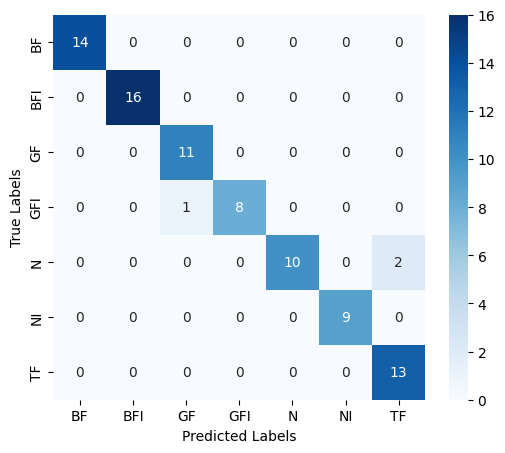

Classification Report:
              precision    recall  f1-score   support

          BF       1.00      1.00      1.00        14
         BFI       1.00      1.00      1.00        16
          GF       0.92      1.00      0.96        11
         GFI       1.00      0.89      0.94         9
           N       1.00      0.83      0.91        12
          NI       1.00      1.00      1.00         9
          TF       0.87      1.00      0.93        13

    accuracy                           0.96        84
   macro avg       0.97      0.96      0.96        84
weighted avg       0.97      0.96      0.96        84



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader, class_names, device):
    """
    Generate and plot the confusion matrix for the given model and dataloader.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    # Gather predictions and true labels
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    #plt.title("Confusion Matrix")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Call the function to plot confusion matrix
plot_confusion_matrix(model, val_loader, dataset.classes, device)


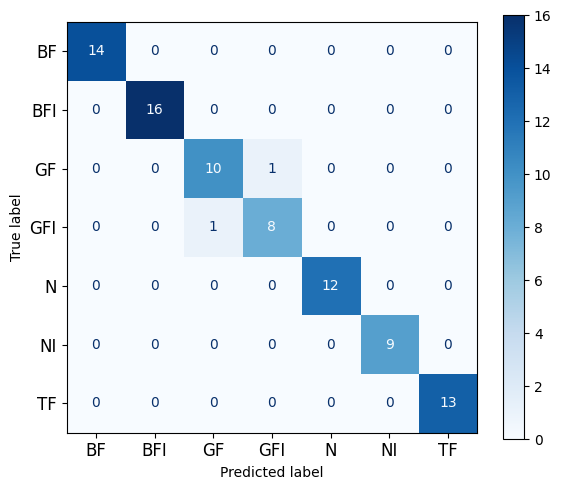

Classification Report:
              precision    recall  f1-score   support

          BF       1.00      1.00      1.00        14
         BFI       1.00      1.00      1.00        16
          GF       0.91      0.91      0.91        11
         GFI       0.89      0.89      0.89         9
           N       1.00      1.00      1.00        12
          NI       1.00      1.00      1.00         9
          TF       1.00      1.00      1.00        13

    accuracy                           0.98        84
   macro avg       0.97      0.97      0.97        84
weighted avg       0.98      0.98      0.98        84



In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader, class_names, device):
    """
    Generate and plot the confusion matrix for the given model and dataloader in the desired design.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    # Gather predictions and true labels
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", ax=ax, colorbar=True)

    # Customize ticks and layout
    plt.xticks(fontsize=12)  # Rotate x-axis labels
    plt.yticks(fontsize=12)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()

    # Save and display
    #plt.savefig("results/confusion_matrix.png", dpi=300)
    plt.show()

    # Print classification report
    print("Classification Report:")
    from sklearn.metrics import classification_report
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Call the function to plot confusion matrix
plot_confusion_matrix(model, val_loader, dataset.classes, device)


C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_2332\590345169.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")
C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_2332\590345169.py:44: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(


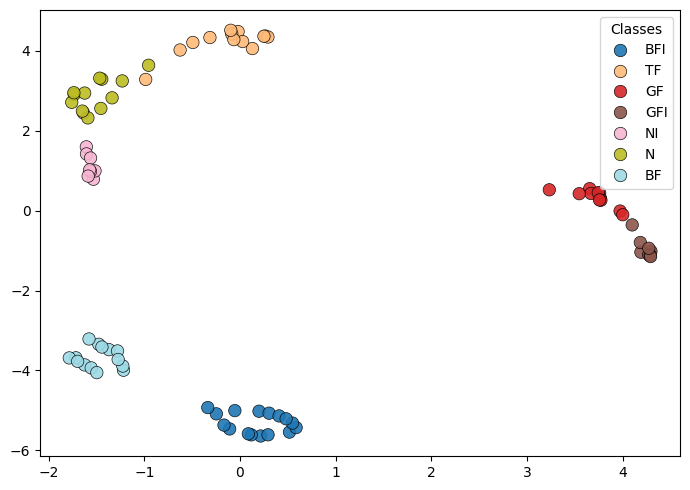

In [22]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def extract_features(model, dataloader, device):
    """
    Extract features using the Vision Transformer for t-SNE visualization.
    """
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            # Move inputs and targets to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Extract features directly from the model (assuming final features or logits)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    
    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

def plot_tsne(features, labels, class_names):
    """
    Plot t-SNE visualization of extracted features.
    """
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)
    
    # Convert numeric labels to class names
    class_labels = [class_names[label] for label in labels]

    # Define the colormap
    cmap = plt.cm.get_cmap("tab20")

    # Plot the t-SNE results
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=class_labels,
        palette=cmap(np.linspace(0, 1, len(class_names))),
        legend="full",
        s=80,  # Marker size
        alpha=0.9,  # Transparency
        edgecolor="black",  # Marker edge color
        linewidth=0.5  # Marker edge width
    )

    plt.legend(title="Classes", fontsize=10, loc='best')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

# Extract features from the validation or test dataset
test_features, test_labels = extract_features(model, val_loader, device)

# Plot t-SNE visualization
plot_tsne(test_features, test_labels, dataset.classes)


c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


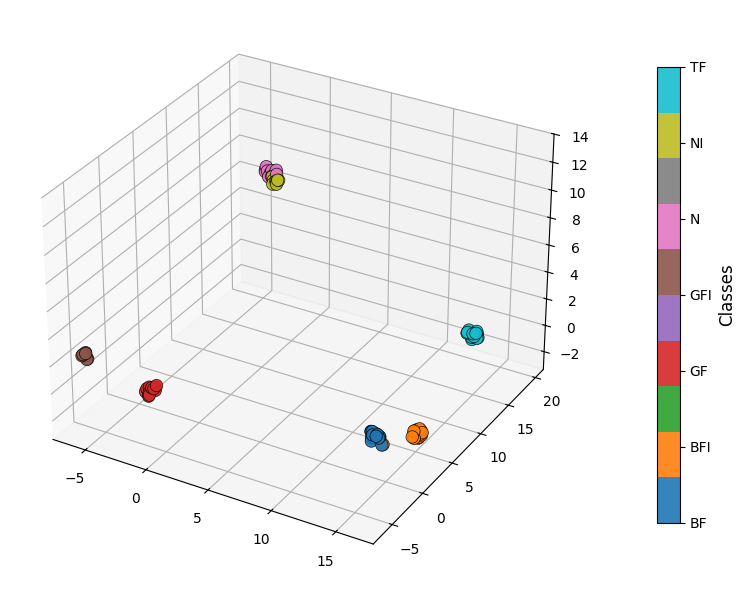

In [36]:
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def extract_features_for_umap(model, dataloader, device):
    """
    Extract features from the model for 3D UMAP visualization.
    """
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            # Move inputs and targets to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Extract features directly from the model
            outputs = model(inputs)  # Get final logits or feature vectors
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    
    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

def plot_3d_umap(features, labels, class_names):
    """
    Plot 3D UMAP visualization of extracted features with a vertical colorbar.
    """
    # Apply UMAP to reduce to 3D
    umap_3d = umap.UMAP(n_components=3, random_state=42)
    umap_results = umap_3d.fit_transform(features)

    # Create a 3D plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Define the colormap
    cmap = cm.tab10

    # Plot points for each class
    scatter = ax.scatter(
        umap_results[:, 0], 
        umap_results[:, 1], 
        umap_results[:, 2], 
        c=labels, 
        cmap=cmap, 
        s=80,  # Marker size
        alpha=0.9,  # Transparency
        edgecolor='black',  # Black border for markers
        linewidth=0.5  # Border width
    )

    # Set axis labels


    # Add a vertical colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.1)
    cbar.set_label("Classes", fontsize=12)
    tick_locations = np.arange(len(class_names))
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(class_names)

    # Legend and layout
    plt.tight_layout()
    plt.show()

# Extract features from the validation or test dataset
test_features, test_labels = extract_features_for_umap(model, val_loader, device)

# Plot 3D UMAP visualization
plot_3d_umap(test_features, test_labels, dataset.classes)
